Import Related Library

In [1]:
import os
import cv2 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore
from tensorflow.keras.applications import ResNet50, MobileNetV2 # type: ignore
from tensorflow.keras.models import Model, load_model # type: ignore
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout # type: ignore
from tensorflow.keras.optimizers import Adam # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore


Import Data

In [ ]:
Input = []
label = []
class_name = []
for name in os.listdir('DATASETALL'):
    class_name.append(name)
    for path in os.listdir(os.path.join('DATASETALL', name)):
        if (".jpg" in path) or (".jpeg" in path) :
            label.append(name)
            Input.append(os.path.join('DATASETALL', name, path))
            Input = list(map(lambda x: x.replace('\\', '/'), Input))
print(class_name)

['AHPND_100x', 'EHP_x100', 'HPV_100x', 'Normal HP_ x100']


In [3]:
for i in range(len(Input)):
    if (label[i] not in Input[i]) and ('.jpg' in Input[i]):
        print(False)

In [15]:
df = pd.DataFrame()
df['images'] = Input
df['label'] = label
df = df.sample(frac = 1).reset_index(drop = True)
df.head()

,images,label
0,DATASETALL/Normal HP_ x100/Normal HP_ x100_0_6...,Normal HP_ x100
1,DATASETALL/Normal HP_ x100/Normal HP_ x100_0_4...,Normal HP_ x100
2,DATASETALL/AHPND_100x/AHPND x100-0422.jpg,AHPND_100x
3,DATASETALL/EHP_x100/EHP_100x415.jpg,EHP_x100
4,DATASETALL/HPV_100x/HPV_100x_0_5424.jpeg,HPV_100x


In [11]:
df["images"] = df["images"].str.strip()
df

,images,label
0,DATASETALL/Normal HP_ x100/Normal x100-0192.jpg,Normal HP_ x100
1,DATASETALL/HPV_100x/HPV_100x_0_5321.jpeg,HPV_100x
2,DATASETALL/EHP_x100/EHP_100x365.jpg,EHP_x100
3,DATASETALL/HPV_100x/HPV_100x_0_9539.jpeg,HPV_100x
4,DATASETALL/HPV_100x/HPV_100x_0_9267.jpeg,HPV_100x
...,...,...
4176,DATASETALL/EHP_x100/EHP x100-0231.jpg,EHP_x100
4177,DATASETALL/EHP_x100/EHP x100-0351.jpg,EHP_x100
4178,DATASETALL/Normal HP_ x100/Normal x100-0240.jpg,Normal HP_ x100
4179,DATASETALL/HPV_100x/HPV_100x112.jpg,HPV_100x


<Axes: xlabel='label', ylabel='count'>

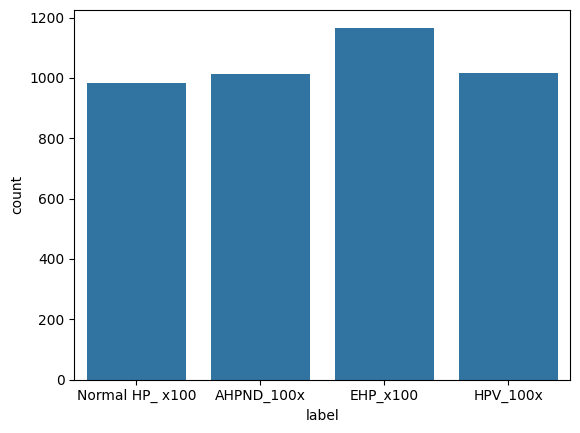

In [17]:
sns.countplot(x = 'label', data = df)

In [18]:
count = df['label'].value_counts()
print(count)

label
EHP_x100           1167
HPV_100x           1018
AHPND_100x         1012
Normal HP_ x100     984
Name: count, dtype: int64


Augmentation Function

In [13]:
datagen_aug = ImageDataGenerator(
    rotation_range = 20, 
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.2, 
    horizontal_flip = True,
    fill_mode = 'nearest'
)

def augment_images(path_folder, output, augment_per_img):
    for img_path in os.listdir(os.path.join('DATASETALL', path_folder)):
        if (".jpg" in img_path) or (".jpeg" in img_path):
            img = image.load_img(os.path.join('DATASETALL', path_folder, img_path))
            x = image.img_to_array(img)
            x = x.reshape((1,) + x.shape)
            i = 0
            for batch in datagen_aug.flow(x, batch_size = 1, save_to_dir = output, save_prefix = path_folder, save_format = 'jpeg'):
                i += 1
                if i >= augment_per_img:
                    break 

# augment_images('HPV_100x', 'DATASETALL/HPV_100x', 1)
# augment_images('AHPND_100x', 'DATASETALL/AHPND_100x', 1)
# augment_images('Normal HP_ x100', 'DATASETALL/Normal HP_ x100', 1)
# augment_images('Normal HP_ x100', 'TEST', 1)
# augment_images('EHP_x100', 'TEST', 1)
# augment_images('HPV_100x', 'TEST', 1)
# augment_images('AHPND_100x', 'TEST', 1)

Split Data

In [19]:
train, test = train_test_split(df, test_size = 0.2, random_state = 42)
train, val = train_test_split(train, test_size = 0.1, random_state = 42)
print(len(train), len(test), len(val)) 

3009 837 335


Class Distribution

In [34]:
train_class_distribution = train["label"].value_counts(normalize = True) * 100
test_class_distribution = test["label"].value_counts(normalize = True) * 100
val_class_distribution = val["label"].value_counts(normalize = True) * 100

In [20]:
set(train['images']).intersection(set(test['images']))

set()

Load Train and Validation

In [10]:
datagen = ImageDataGenerator(rescale = 1./255)

train_generator = datagen.flow_from_dataframe(
    dataframe = train,
    x_col = "images",
    y_col = "label",   
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical"
)

val_generator = datagen.flow_from_dataframe(
    dataframe = val,
    x_col = "images",
    y_col = "label",
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical"
)

Found 3009 validated image filenames belonging to 4 classes.
Found 335 validated image filenames belonging to 4 classes.


Model

In [82]:
base_model = MobileNetV2(weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation = 'relu')(x)
x = Dense(4, activation = 'softmax')(x)  

model = Model(inputs = base_model.input, outputs = x)

In [10]:
model.compile(optimizer = Adam(learning_rate = 0.0001),
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

In [5]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,468 (9.24 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Training

In [ ]:
early_stopping = EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)

history = model.fit(train_generator, validation_data = val_generator, epochs = 10, batch_size = 32, callbacks = [early_stopping])

c:\Users\BOSS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
 5/95 ━━━━━━━━━━━━━━━━━━━━ 2:34 2s/step - accuracy: 0.1950 - loss: 1.6576

KeyboardInterrupt: 

Plot Graph

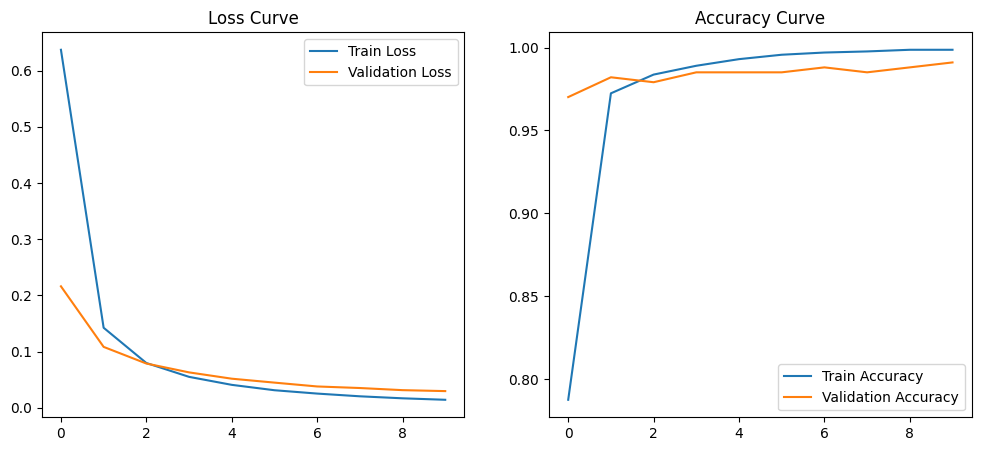

In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize = (12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_loss, label = "Train Loss")
plt.plot(val_loss, label = "Validation Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(train_acc, label = "Train Accuracy")
plt.plot(val_acc, label = "Validation Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.show()


Accuracy and Loss

In [11]:
test_generator = datagen.flow_from_dataframe(
    dataframe = test,
    x_col = "images",
    y_col = "label",
    target_size = (224, 224),
    batch_size = 32,
    class_mode = "categorical",
    shuffle = False
)

Found 837 validated image filenames belonging to 4 classes.


In [ ]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.2%} Test Loss: {loss}")

Found 837 validated image filenames belonging to 4 classes.


c:\Users\BOSS\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


27/27 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step - accuracy: 0.9994 - loss: 0.0132
Test Accuracy: 99.88% Test Loss: 0.017855005338788033


Save Model

In [15]:
# model.save("MobileNetV2_Medical_Classification.h5")

In [2]:
model = load_model("MobileNetV2_Medical_Classification.h5") 

Confusion Matrix

27/27 ━━━━━━━━━━━━━━━━━━━━ 47s 2s/step


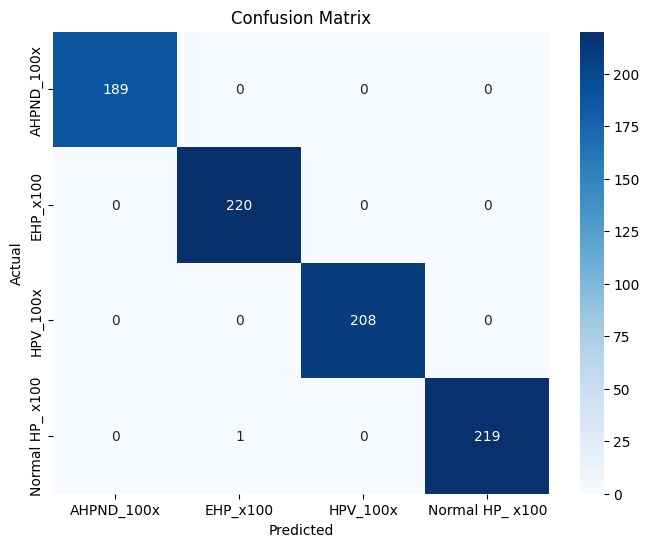

In [12]:
class_labels = list(test_generator.class_indices.keys())
y_test = test_generator.classes
y_pred = model.predict(test_generator)  
y_pred_classes = np.argmax(y_pred, axis = 1) 

cm = confusion_matrix(y_test, y_pred_classes)

plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = "d", cmap = "Blues", xticklabels = class_labels, yticklabels = class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [13]:
print(classification_report(y_test, y_pred_classes, target_names = class_labels))

                 precision    recall  f1-score   support

     AHPND_100x       1.00      1.00      1.00       189
       EHP_x100       1.00      1.00      1.00       220
       HPV_100x       1.00      1.00      1.00       208
Normal HP_ x100       1.00      1.00      1.00       220

       accuracy                           1.00       837
      macro avg       1.00      1.00      1.00       837
   weighted avg       1.00      1.00      1.00       837



In [23]:
train_generator.class_indices.items()

dict_items([('AHPND_100x', 0), ('EHP_x100', 1), ('HPV_100x', 2), ('Normal HP_ x100', 3)])

Predict Function

In [ ]:
def predict_img(img_path):
    img = image.load_img(img_path, target_size = (224, 224))  
    img_array = image.img_to_array(img)  
    img_array = np.expand_dims(img_array, axis = 0) 
    img_array = img_array / 255.0 
  
    predictions = model.predict(img_array)  
    predicted_class = np.argmax(predictions, axis = 1)

    class_labels = {v: k for k, v in [('AHPND_100x', 0), ('EHP_x100', 1), ('HPV_100x', 2), ('Normal HP_ x100', 3)]} 

    predicted_label = class_labels[predicted_class[0]]
    print(f"Predicted label: {predicted_label}")
    return predicted_label

Predict With Test set

In [40]:
test['images']

1263                  DATASETALL/HPV_100x/HPV_100x284.jpg
1163      DATASETALL/Normal HP_ x100/Normal x100-0237.jpg
1988         DATASETALL/AHPND_100x/AHPND_100x_0_9845.jpeg
810                 DATASETALL/EHP_x100/EHP x100-0275.jpg
3966                DATASETALL/EHP_x100/EHP x100-0516.jpg
                              ...                        
1777    DATASETALL/Normal HP_ x100/Normal HP_ x100_0_4...
910              DATASETALL/HPV_100x/HPV_100x_0_6506.jpeg
1769    DATASETALL/Normal HP_ x100/Normal HP_ x100_0_8...
2835            DATASETALL/AHPND_100x/AHPND x100-0064.jpg
2177                  DATASETALL/EHP_x100/EHP_100x405.jpg
Name: images, Length: 837, dtype: object

In [52]:
print(predict_img("D:/Senior Project/Normal 20X/DOF normal x20-0001.jpg"))
predict_img("DATASETALL/Normal HP_ x100/Normal x100-0237.jpg") 

0.66194963 0.061383072
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted label: EHP_x100
EHP_x100
0.5539381 0.06950149
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted label: Normal HP_ x100


'Normal HP_ x100'

In [ ]:
for i, row in test.iterrows():
    img_path = str(row['images'])  
    true_label = row['label']      
    predicted_label = predict_img(img_path)  
    if true_label == predicted_label:
        pass
    else:
        print(False)
    # print(f"True: {true_label} | Predicted: {predicted_label}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


KeyboardInterrupt: 

Test Add Noise

In [ ]:
def add_noise(img_path, noise_level = 25):
    img = cv2.imread(img_path)  
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    noise = np.random.randint(-noise_level, noise_level, img.shape, dtype = 'int16')  
    noisy_img = np.clip(img + noise, 0, 255).astype('uint8')  
    noisy_img = cv2.resize(noisy_img, (224, 224))
    img = cv2.resize(img, (224, 224))

    # plt.imshow(img)
    # plt.axis("off")
    # plt.show()

    # plt.imshow(noisy_img)
    # plt.axis("off")
    # plt.show()

    return noisy_img

for i, row in test.iterrows():
    img_path = str(row['images']) 
    noisy_img = add_noise(img_path)
    noisy_img = cv2.resize(noisy_img, (224, 224))
    img_array = image.img_to_array(noisy_img)
    img_array = np.expand_dims(img_array, axis = 0) / 255.0
    predictions = model.predict(img_array)
    predicted_class = np.argmax(predictions, axis = 1)
    class_labels = {v: k for k, v in train_generator.class_indices.items()} 
    predicted_label = class_labels[predicted_class[0]]
    if predicted_label in img_path:
        pass
    else:
        print(img_path, predicted_label)

Test Unseen Image

In [59]:
for name in os.listdir('D:/Senior Project/AHPND 20X'):
    path = "D:/Senior Project/AHPND 20X/" + name
    predict_img(path)

0.6874693 0.074927345
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted label: AHPND_100x
0.6856143 0.06639344
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
Predicted label: AHPND_100x
0.65356654 0.07564862
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted label: AHPND_100x
0.6856067 0.07514614
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted label: EHP_x100
0.68826026 0.06828103
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
Predicted label: Normal HP_ x100
0.673264 0.07333778
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted label: AHPND_100x
0.66582876 0.07063035
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted label: AHPND_100x
0.6513208 0.07379927
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted label: AHPND_100x
0.66340214 0.069945864
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
Predicted label: EHP_x100
0.66322225 0.07508964
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Predicted label: EHP_x100
0.6594417 0.09188305
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
Predicted label: AHPND_100x
0.6709868 0.08795466
1/1 ━━━━━━━━━━━━━